### Importing Libraries and data 

In [3]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = 'sPKtRznsSx8Enn-7L1Mo'


In [5]:
# Importing the Inflation rates Data "Consumer Price Index - Germany" variable.

data = quandl.get('RATEINF/CPI_DEU')

In [6]:
data.head(5)

,Value
Date,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


In [7]:
data.shape

(374, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

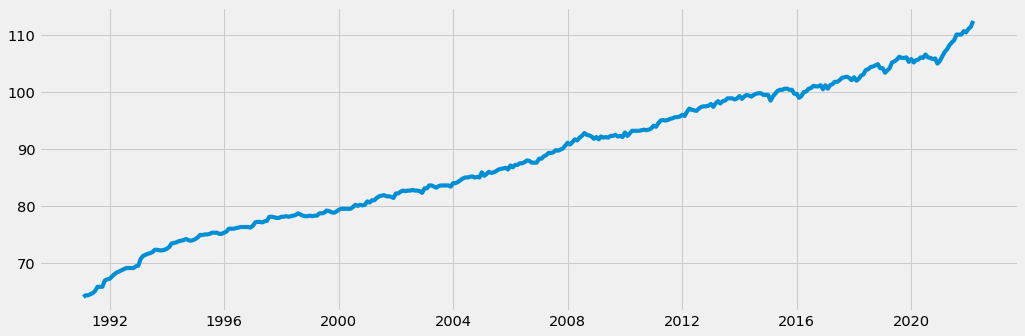

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=75)
plt.plot(data)

I chose not to create a subset with this data. As the data is from 1988 to 2020, there are no irrelevant historical events and no forecasted data in this time frame that would result in bias in the analysis.

In [15]:
# Check for missing values 

data.isnull().sum() 

Value    0
dtype: int64

### Time-series analysis: decomposition 

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

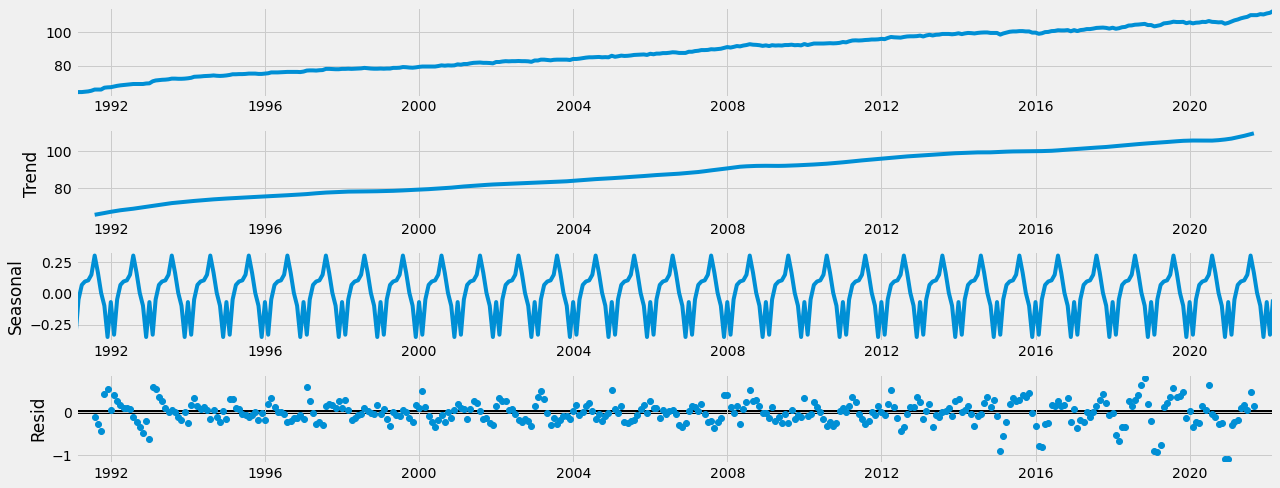

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

As the level and trend are different, this informs us that the data is unsmoothed. The seasonality component displays fluctuations indicating season fluctuations at a regular interval. The residual shows that there is too much unexplained noise. Overall, there is an upward trend, seasonality is present, and there is too much residual noise left over. 

### Testing for stationarity


In [21]:
# Dickery Fuller test
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.177732
p-value                          0.995828
Number of Lags Used             14.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


The test statistic is -1.17 and the p-value is 0.99 which indicates the test result is not significant as it is more than 0.05. Using the critical value (5%) which is -2.8, it is much smaller than the test statistic. This means you cannot reject the null hypothesis. This indicates that there is a unit root in the data and that the data is likely non-stationary.

In [ ]:
#checking autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data)
plt.show()

The autocorrelation shows that there are many lags beyond the confidence interval likely indicating the data is non-stationary and there is autocorrelated data. The Dickey-Fuller test was correct in stating the data is non-stationary. 

### Stationarizing data

In [25]:
data_diff = data - data.shift(1) 

In [26]:
# Dropping NAN values
data_diff.dropna(inplace = True)

In [27]:
data_diff.head()

,Value
Date,
1991-02-28,0.3
1991-03-31,0.0
1991-04-30,0.2
1991-05-31,0.2
1991-06-30,0.4


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

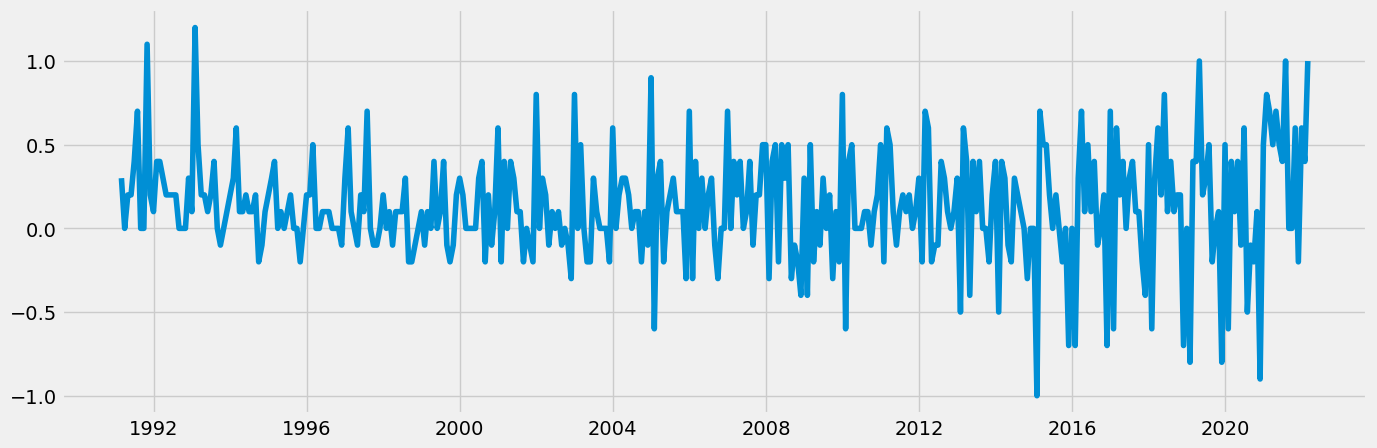

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.077854
p-value                          0.028236
Number of Lags Used             13.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


With differencing, the test-statistic (-3.07) is now smaller than the critical values at 5% (-2.8) and at 10% (-2.5). The null hypothesis can be rejected and the series is now stationary. The test result is also significant as the p-value is less than 0.05.

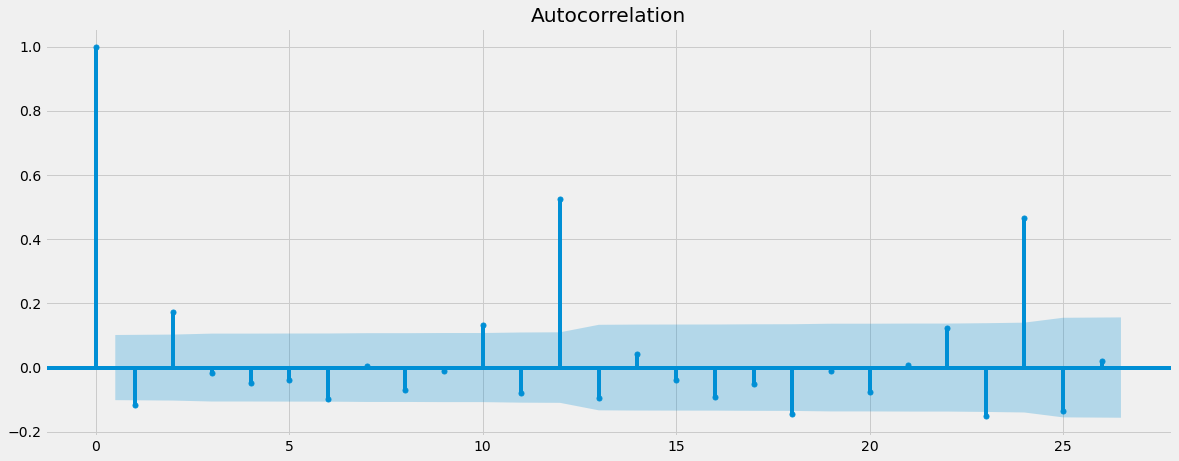

In [31]:
plot_acf(data_diff)
plt.show()

The autocorrelation is significantly different with few autocorrelated terms. However, as there are still lags outside of the confidence interval, it indicates a weak stationarity. As there are less than 10 significant lags, a second round of differencing is not necessary.